In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pandas_profiling

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer

In [43]:
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')

In [54]:
def split_url(url):
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    stemmer = SnowballStemmer(language="english")
    sent = tokenizer.tokenize(url)
    sent = [stemmer.stem(word) for word in sent]
    sent = ' '.join(sent)
    return sent

def vectorize(corpus):
    tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df = 3, lowercase=True, max_features=150000, stop_words=['url', 'label', 'stemmed', 'words_count', 'len'])
    url_vec = tfidf.fit_transform(corpus)
    svdT = TruncatedSVD(n_components=350)
    url_vec = svdT.fit_transform(url_vec)
    #temp_df = pd.DataFrame(url_vec.toarray(), columns=vectorizer.get_feature_names())
    return url_vec

def add_features(df):
    df['label'] = df['label'].apply(lambda label: 1 if label == 'Unsafe' else 0)
    df['stemmed'] = df['url'].apply(split_url)
    df['words_count'] = df['stemmed'].apply(lambda url: len(url.split()))
    
    #vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df = 3, lowercase=True, max_features=150000, stop_words=['url', 'label', 'stemmed', 'words_count', 'len'])
    #url_vec = vectorizer.fit_transform(df['stemmed'])
    #temp_df = pd.DataFrame(url_vec.toarray(), columns=vectorizer.get_feature_names())
    df['len'] = df['url'].apply(lambda url: len(url))
    url_vecs = pd.DataFrame(vectorize(df['stemmed']))
    df = pd.concat([df, url_vecs], axis=1)
    return df
    
def split(df):
    train_text, temp_text, \
    train_labels, temp_labels = train_test_split(df.drop(['url', 'stemmed'], axis=1),   
                                                 df['label'],
                                                 random_state = 42,
                                                 test_size = 0.3,
                                                 stratify=df['label'])
    val_text, test_text, \
    val_labels, test_labels = train_test_split(temp_text,
                                              temp_labels,
                                              random_state = 42,
                                              test_size = 0.5,
                                              stratify=temp_labels)
   
    return train_text.drop(['label'], axis=1), \
           train_labels, \
           val_text.drop(['label'], axis=1), \
           val_labels, \
           test_text.drop(['label'], axis=1), \
           test_labels

def preprocess(df):
    df = add_features(df)
    return split(df)

def train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels):
    gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', 
                             loss_function='Logloss', od_type='Iter', od_wait=20)
    eval_pool = Pool(val_data, val_labels)
    gbm.fit(train_data, train_labels, eval_set=eval_pool, use_best_model=True)
    gbm.save_model('catboost_1',
                   format="cbm",
                   export_parameters=None,
                   pool=None)
    pred_labels = gbm.predict(test_data)
    score = [roc_auc_score(pred_labels, test_labels), f1_score(pred_labels, test_labels)]
    
    print('roc_auc: ', score[0])
    print('f1: ', score[1])

    average_precision = average_precision_score(pred_labels, test_labels)

    disp = plot_precision_recall_curve(gbm, test_data, test_labels)
    disp.ax_.set_title('2-class Precision-Recall curve: ')
    
    return gbm

def get_cross_val(model, train_data, train_labels):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, train_data, train_labels, cv=skf, scoring='roc_auc')
    return cv_results

In [28]:
df = pd.read_csv('urls.csv')
train_data, train_labels, val_data, val_labels, test_data, test_labels = preprocess(df)

In [30]:
train_data.head()

,words_count,len,0,1,2,3,4,5,6,7,...,340,341,342,343,344,345,346,347,348,349
47512,3,14,0.127826,0.000104,0.000125,0.000314,0.000009,0.000142,-0.000434,-0.000009,...,-0.000585,-0.003759,0.001438,-0.002770,0.001282,0.001799,0.002334,0.000921,-0.000521,-0.004459
1529,2,10,0.000062,0.000982,0.005646,0.999945,-0.001586,-0.001636,-0.000559,-0.000777,...,0.000278,-0.000044,-0.000320,-0.000135,-0.000320,0.000071,0.000403,0.000257,0.000180,0.000311
32732,2,24,0.999963,-0.000171,-0.000229,-0.000082,-0.000710,-0.000189,-0.003248,-0.000121,...,-0.000018,-0.000010,-0.000013,-0.000009,-0.000017,0.000020,-0.000003,-0.000004,0.000030,-0.000008
2490,2,9,0.003288,0.008213,0.009729,0.000118,0.002199,0.000119,0.970208,-0.004114,...,0.000240,0.000036,0.000021,-0.000073,0.000003,0.000065,-0.000294,0.000189,0.000329,-0.000115
59312,2,20,0.999963,-0.000171,-0.000229,-0.000082,-0.000710,-0.000189,-0.003248,-0.000121,...,-0.000018,-0.000010,-0.000013,-0.000009,-0.000017,0.000020,-0.000003,-0.000004,0.000030,-0.000008


In [32]:
gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', loss_function='Logloss',
                        od_type='Iter')
cv_results = cross_val_score(gbm, train_data, train_labels, cv=skf, scoring='roc_auc')
print(cv_results)

[0.99281044 0.99231222 0.98689467 0.98823062 0.98649724]


roc_auc:  0.9793018734136085
f1:  0.9502407704654895


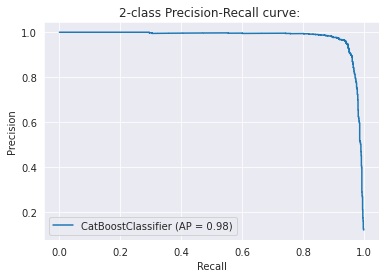

In [55]:
gbm = train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [56]:
df.shape

(84751, 5)